# Descripcipción del proyecto

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. Tu objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, utilizarás un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85.

## Inicialización

In [2]:

import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm


In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI
# %config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [4]:
# esto es para usar progress_apply, puedes leer más en https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Cargar datos

In [5]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

print(df_reviews.head())
print(df_reviews.info())

      tconst title_type primary_title original_title  start_year end_year  \
0  tt0068152      movie             $              $        1971       \N   
1  tt0068152      movie             $              $        1971       \N   
2  tt0313150      short          '15'           '15'        2002       \N   
3  tt0313150      short          '15'           '15'        2002       \N   
4  tt0313150      short          '15'           '15'        2002       \N   

  runtime_minutes  is_adult              genres  average_rating  votes  \
0             121         0  Comedy,Crime,Drama             6.3   2218   
1             121         0  Comedy,Crime,Drama             6.3   2218   
2              25         0  Comedy,Drama,Short             6.3    184   
3              25         0  Comedy,Drama,Short             6.3    184   
4              25         0  Comedy,Drama,Short             6.3    184   

                                              review  rating   sp  pos  \
0  The pakage impl

In [6]:
print(df_reviews.isnull().sum())
print(df_reviews.duplicated().sum())

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     2
votes              2
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64
0


0    23715
1    23616
Name: pos, dtype: int64


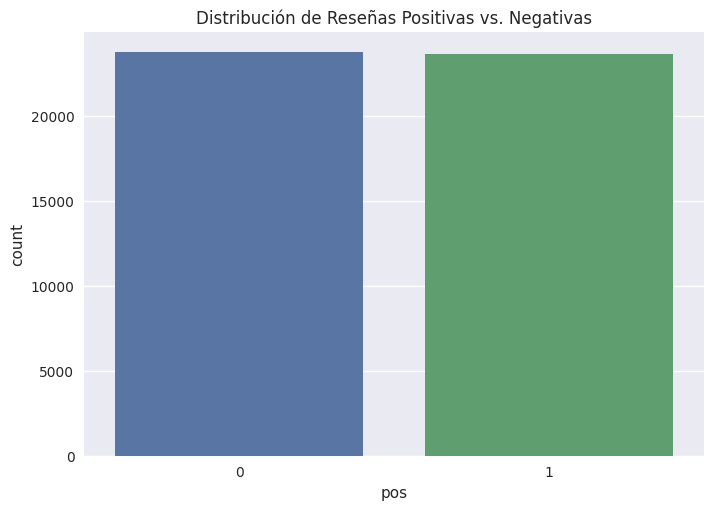

In [8]:
print(df_reviews['pos'].value_counts())
sns.countplot(x='pos', data=df_reviews)
plt.title('Distribución de Reseñas Positivas vs. Negativas')
plt.show()

 El conjunto de datos de IMDB está bien balanceado, con una cantidad similar de reseñas positivas (1) y negativas (0). Siendo este el caso, la métrica de accuracy puede ser útil, pero el F1-score sigue siendo una métrica más robusta.

 

## EDA

Veamos el número de películas y reseñas a lo largo de los años.

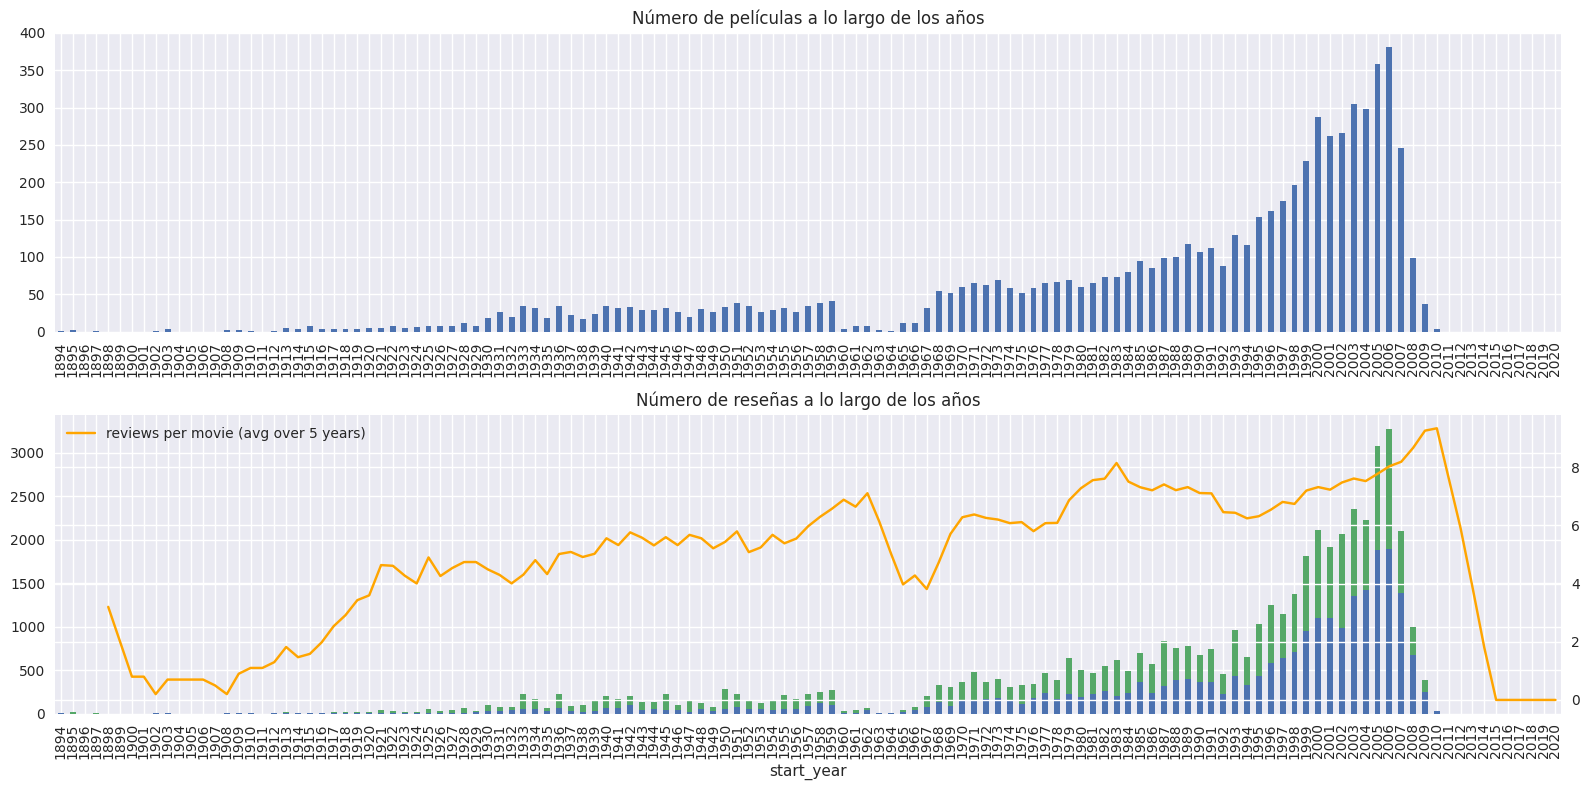

In [7]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de reseñas a lo largo de los años')

fig.tight_layout()

Veamos la distribución del número de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto)

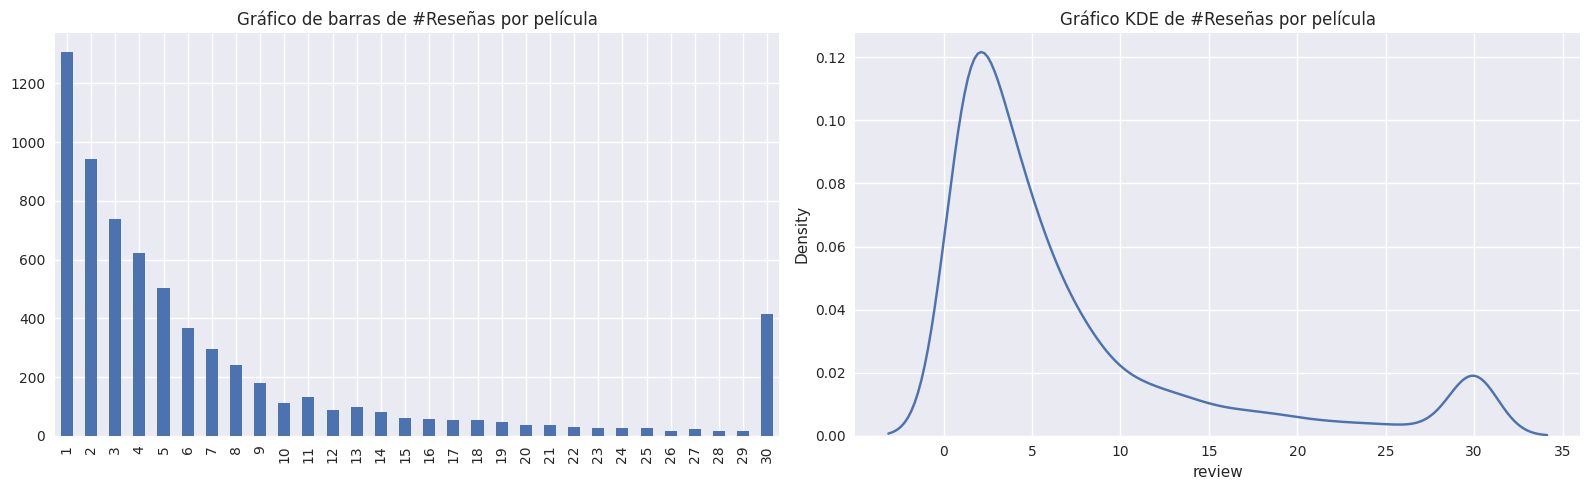

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

fig.tight_layout()

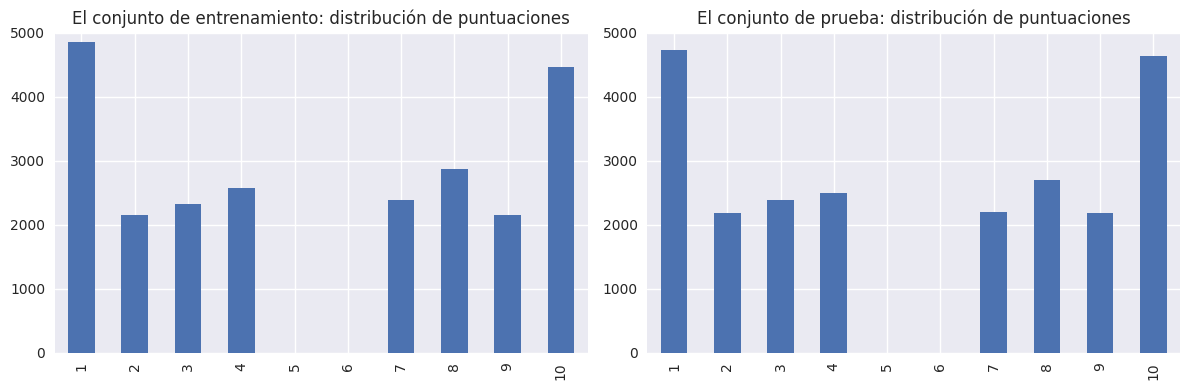

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()

Distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos

/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


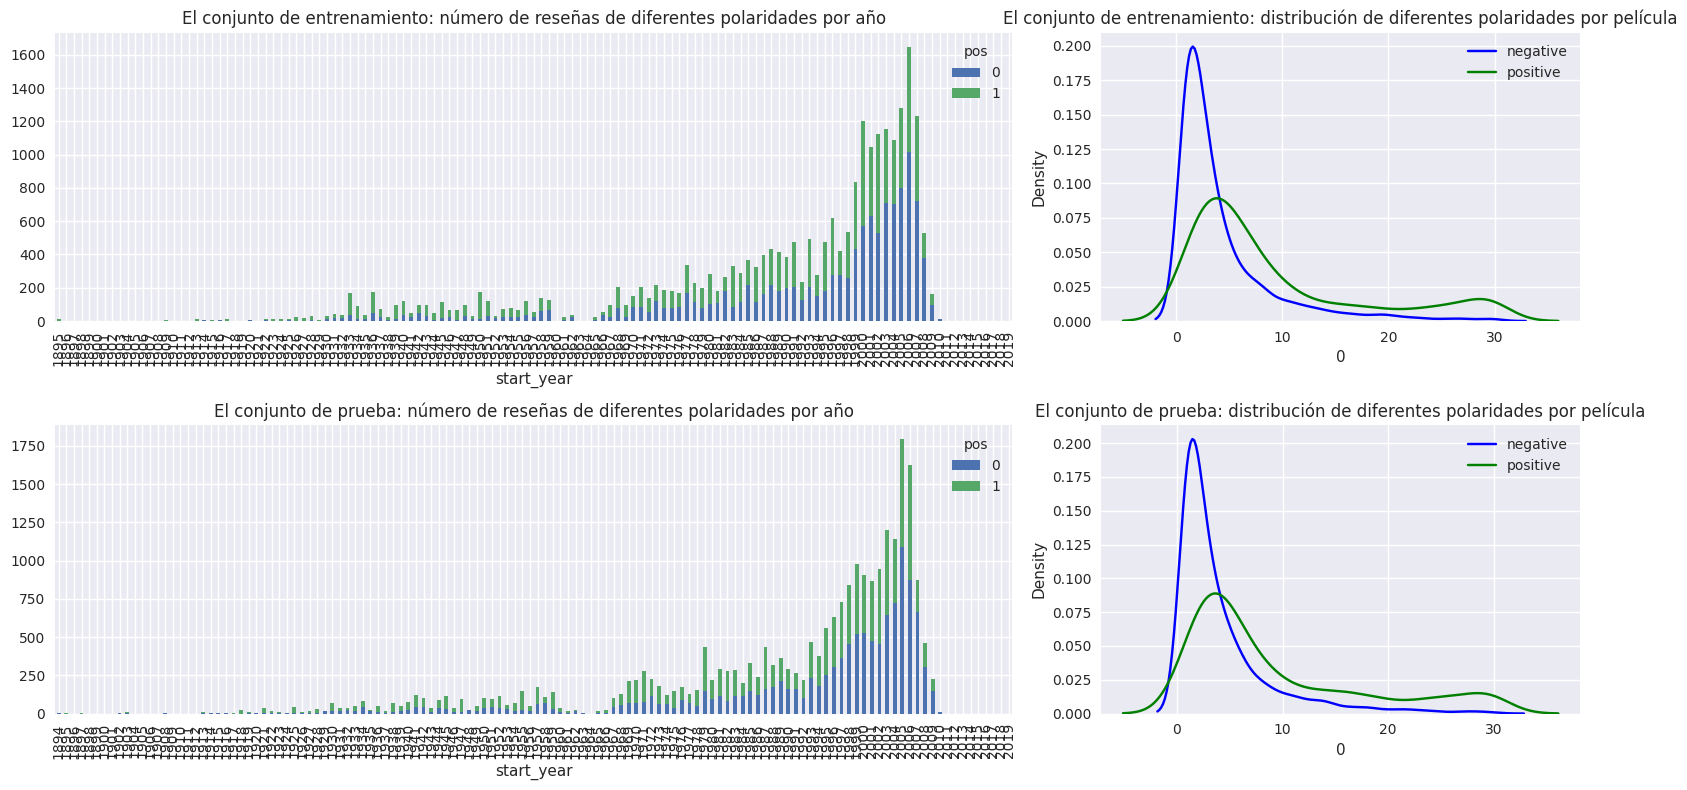

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()

## Procedimiento de evaluación

Composición de una rutina de evaluación que se pueda usar para todos los modelos en este proyecto

In [7]:
import sklearn.metrics as metrics
def evaluate_model(model, train_features, train_target, test_features, test_target):

    eval_stats = {}

    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):

        eval_stats[type] = {}

        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]

        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]

        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps

        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1')

        # ROC
        ax = axs[1]
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')
        ax.set_title(f'Curva ROC')

        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)

    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))

    print(df_eval_stats)

    return

¿Qué hace esta función?
Propósito: Evalúa un modelo de clasificación usando múltiples métricas y visualizaciones

Input: Modelo entrenado + datos de train/test  
Output: Gráficos + tabla de métricas

¿Què muestra?

#### 1. Gráfico F1 Score vs Threshold
- ¿Qué muestra? Cómo cambia F1 según el umbral de decisión
- Utilidad: Encontrar el mejor punto de corte
- Marcadores: Umbrales comunes (0.2, 0.4, 0.5, 0.6, 0.8)
- Más detalles:  Muestra cómo cambia el valor F1 del modelo a medida que ajustas el umbral de decisión. El umbral por defecto en muchos modelos es 0.5. Esta gráfica te permite encontrar el punto óptimo donde el F1 es más alto, que es el mejor balance entre precisión y exhaustividad para tu modelo. .

#### 2. Curva ROC (Receiver Operating Characteristic)
- Ejes: FPR (False Positive Rate) vs TPR (True Positive Rate)
- Línea diagonal: Modelo aleatorio
- AUC: Área bajo la curva (más alto = mejor)
- Más detalles: : Esta gráfica representa la tasa de verdaderos positivos (TPR o recall) frente a la tasa de falsos positivos (FPR). La métrica ROC AUC (Area Under the Curve) resume el rendimiento del clasificador en un solo número. Un valor de 1.0 es perfecto, mientras que 0.5 indica que el modelo no es mejor que adivinar al azar.

#### 3. Curva PRC (Precision-Recall)
- Ejes: Recall vs Precision
- AP: Average Precision Score
- Útil: Especialmente para datasets desbalanceados
- Más detalles: Esta curva es particularmente útil para conjuntos de datos con clases desequilibradas. Muestra la relación entre la precisión y la exhaustividad. La métrica APS (Average Precision Score) resume el área bajo esta curva. Un valor más alto de APS indica un mejor rendimiento del modelo.

### Resumen de la Lógica Principal
La función toma como entrada el modelo y los datos de entrenamiento y prueba.

Crea una figura con tres subgráficos para mostrar las tres métricas visuales.

Itera sobre los datos de entrenamiento y prueba para calcular y graficar las métricas.

Para cada conjunto de datos (train y test):

Genera las predicciones de probabilidad (pred_proba). Esto es clave, ya que te permite evaluar el modelo en diferentes umbrales, no solo en el por defecto.

Calcula los datos para los tres tipos de gráficos: F1, ROC y PRC.

En el primer gráfico (F1), plotea el valor F1 para diferentes umbrales y marca el punto con el F1 más alto.

En el segundo (ROC), plotea la curva ROC y muestra el valor ROC AUC.

En el tercero (PRC), plotea la curva de precisión-exhaustividad y muestra el valor APS.

Al final, la función imprime una tabla de pandas (df_eval_stats) que resume las métricas clave (Accuracy, F1, APS, y ROC AUC) para ambos conjuntos, lo que te permite comparar el rendimiento del modelo en los datos que vio durante el entrenamiento y en los datos nuevos (de prueba).

## División entrenamiento / prueba

Por fortuna, todo el conjunto de datos ya está dividido en partes de entrenamiento/prueba; 'ds_part' es el indicador correspondiente.

In [8]:
df_train = df_reviews[df_reviews['ds_part'] == 'train'].copy()
df_test = df_reviews[df_reviews['ds_part'] == 'test'].copy()

# Features (X) y Target (y)
X_train_text = df_train['review']
y_train = df_train['pos']

X_test_text = df_test['review']
y_test = df_test['pos']

print(df_train.shape)
print(df_test.shape)

(23796, 17)
(23535, 17)


## Normalización, tokenización y lematización

Suponemos que todos los modelos a continuación aceptan textos en minúsculas y sin dígitos, signos de puntuación, etc.

In [9]:
import re
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

lemmatizer = WordNetLemmatizer()
stop_words = set(nltk_stopwords.words('english')) # Las reseñas están en inglés

def preprocess_text(text):
    # 1. Limpieza con Expresiones Regulares:
    #    Quitamos etiquetas HTML y dejamos solo letras y apóstrofos.
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'[^a-zA-Z\']', ' ', text)

    # 2. Tokenización y Lematización:
    #    Convertimos a minúsculas, tokenizamos y lematizamos cada palabra.
    tokens = word_tokenize(text.lower())
    lemmas = [lemmatizer.lemmatize(token) for token in tokens]

    # 3. Eliminar stop words y unir de nuevo a una cadena
    clean_text = " ".join([word for word in lemmas if word not in stop_words and word.isalpha()])
    
    return clean_text

# Aplicar la función a nuestros datos de texto
print("Preprocesando textos de entrenamiento...")
X_train_preprocessed = X_train_text.apply(preprocess_text)
print(X_train_preprocessed.head())

print("Preprocesando textos de prueba...")
X_test_preprocessed = X_test_text.apply(preprocess_text)
print(X_test_preprocessed.head())

print("Todos los datos han sido preprocesados")

Preprocesando textos de entrenamiento...
0    pakage implies warren beatty goldie hawn pulli...
1    hell get made presenting caper comedy misbegot...
7    true story carlson raider army training film a...
8    titled little film true except name island fac...
9    movie ho story carlson makin island raider wa ...
Name: review, dtype: object
Preprocesando textos de prueba...
2    real story film seems like fly wall drama docu...
3    um serious film troubled teen singapore countr...
4    totally agree garryjohal singapore comment fil...
5    first movie seen singapore great know lot asia...
6    yes non singaporean ca see big deal film refer...
Name: review, dtype: object
Todos los datos han sido preprocesados


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorización TF-IDF

print("Realizando Vectorización TF-IDF")
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_preprocessed)
X_test_tfidf = tfidf_vectorizer.transform(X_test_preprocessed)

print("Se Ha Finalizado la Vectorización TF-IDF")


Realizando Vectorización TF-IDF
Se Ha Finalizado la Vectorización TF-IDF


### Modelo 0 - Constante

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


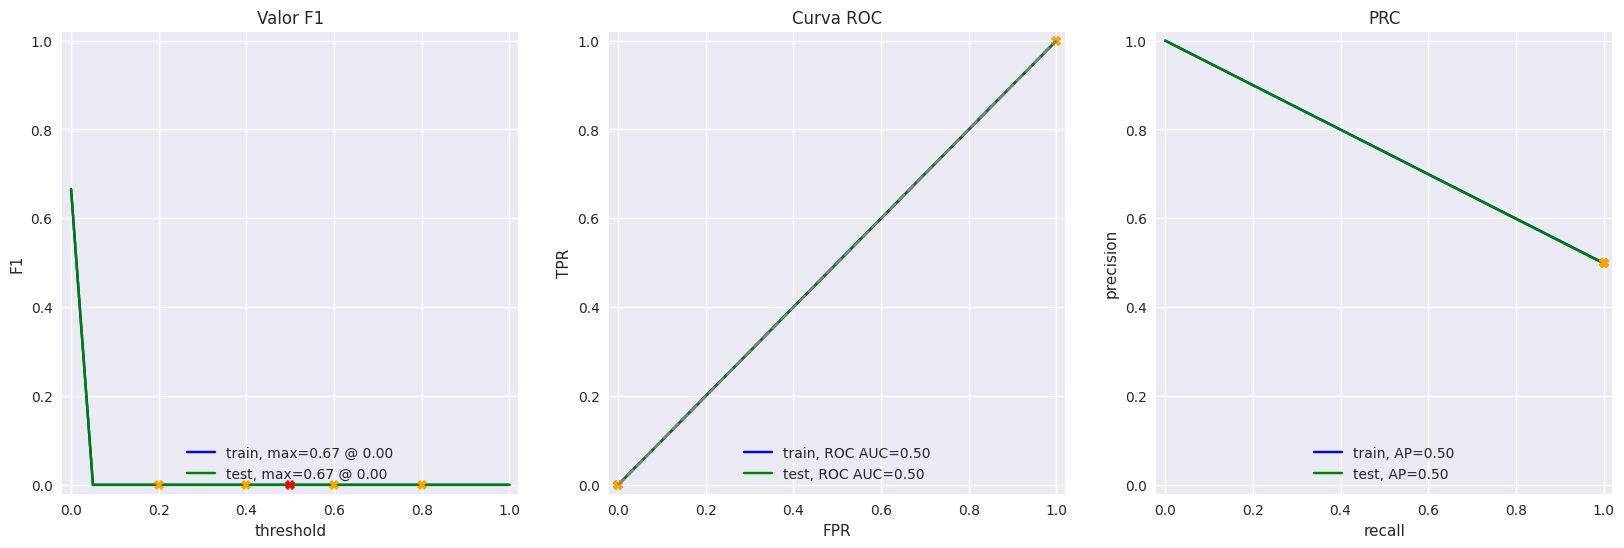

In [28]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score

# Usando la estrategia más frecuente
dummy_model = DummyClassifier(strategy='most_frequent')
dummy_model.fit(X_train_tfidf, y_train)
dummy_pred = dummy_model.predict(X_test_tfidf)

#dummy_f1 = f1_score(y_test, dummy_pred)

evaluate_model(dummy_model, X_train_tfidf, y_train, X_test_tfidf, y_test)

### Modelo 1 - NLTK, TF-IDF y LR

TF-IDF

In [18]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from nltk.corpus import stopwords

          train  test
Accuracy   0.91  0.87
F1         0.91  0.87
APS        0.97  0.94
ROC AUC    0.97  0.95


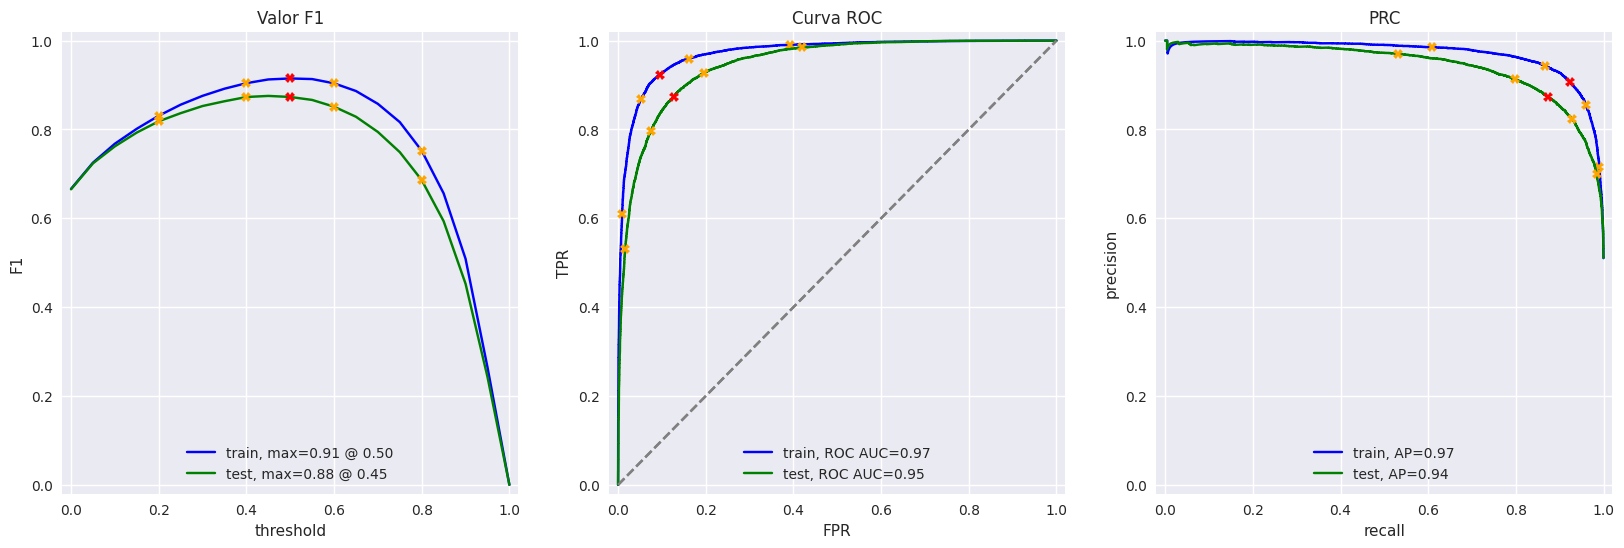

In [19]:
# Suponiendo que ya tienes X_train_tfidf, X_test_tfidf, y_train, y_test
# Definimos el modelo
model_1 = LogisticRegression(solver='liblinear', random_state=42)

# Entrenar el modelo
model_1.fit(X_train_tfidf, y_train)

# Evaluar el modelo con la función
evaluate_model(model_1, X_train_tfidf, y_train, X_test_tfidf, y_test)

### Modelo 3 - spaCy, TF-IDF y LR

In [25]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [26]:
def text_preprocessing_3(text):

    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]

    return ' '.join(tokens)

In [28]:
# Preprocesar los datos de entrenamiento y prueba
X_train_spacy = X_train_preprocessed.apply(text_preprocessing_3)
X_test_spacy = X_test_preprocessed.apply(text_preprocessing_3)

print(f' Preprocesamiento Finalizado')

# Vectorizar: TfidfVectorizer para convertir el texto preprocesado en matrices de características. 

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf_spacy = tfidf_vectorizer.fit_transform(X_train_spacy)
X_test_tfidf_spacy = tfidf_vectorizer.transform(X_test_spacy)

print(f'Vectorización Finalizada')

 Preprocesamiento Finalizado
Vectorización Finalizada


In [29]:
# Entrenar
from sklearn.linear_model import LogisticRegression
model_3 = LogisticRegression(solver='liblinear', random_state=42)
model_3.fit(X_train_tfidf_spacy, y_train)

print(f'Entrenamiento Finalizado')

Entrenamiento Finalizado


          train  test
Accuracy   0.91  0.88
F1         0.92  0.88
APS        0.97  0.95
ROC AUC    0.97  0.95


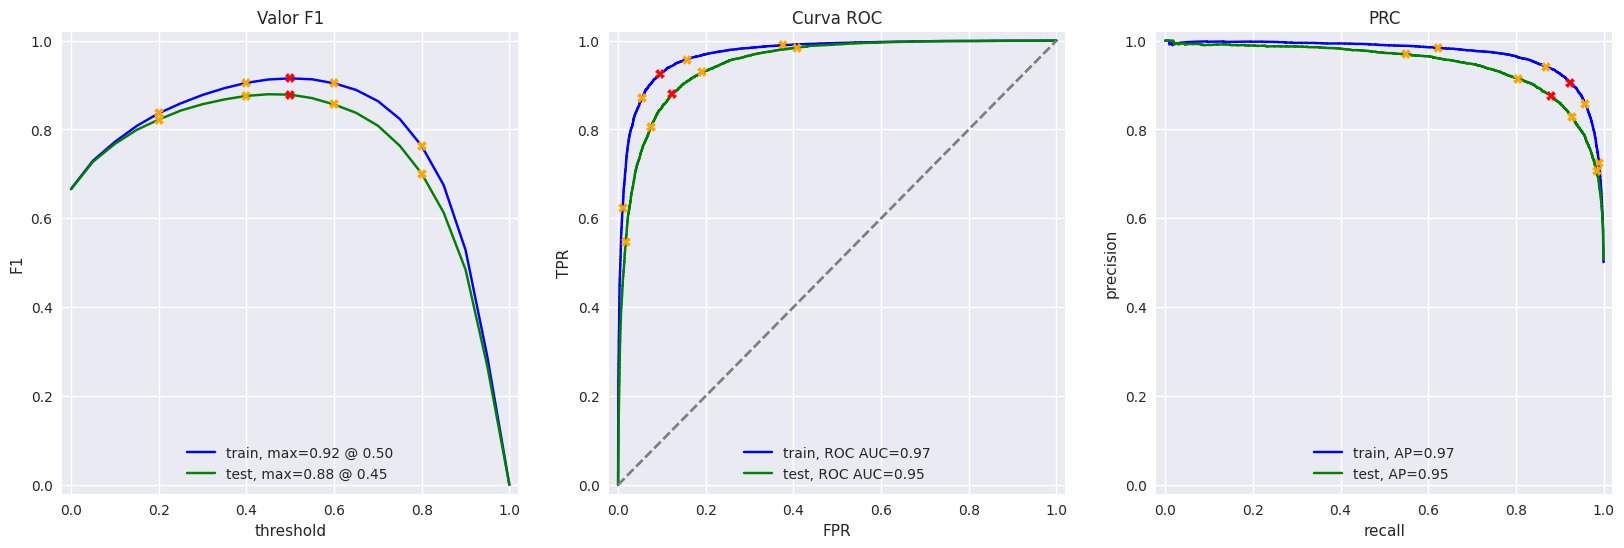

In [30]:
#Evaluar
evaluate_model(model_3, X_train_tfidf_spacy, y_train, X_test_tfidf_spacy, y_test)

### Modelo 4 - spaCy, TF-IDF y LGBMClassifier

In [22]:
from lightgbm import LGBMClassifier

          train  test
Accuracy   0.91  0.86
F1         0.91  0.86
APS        0.97  0.93
ROC AUC    0.97  0.94


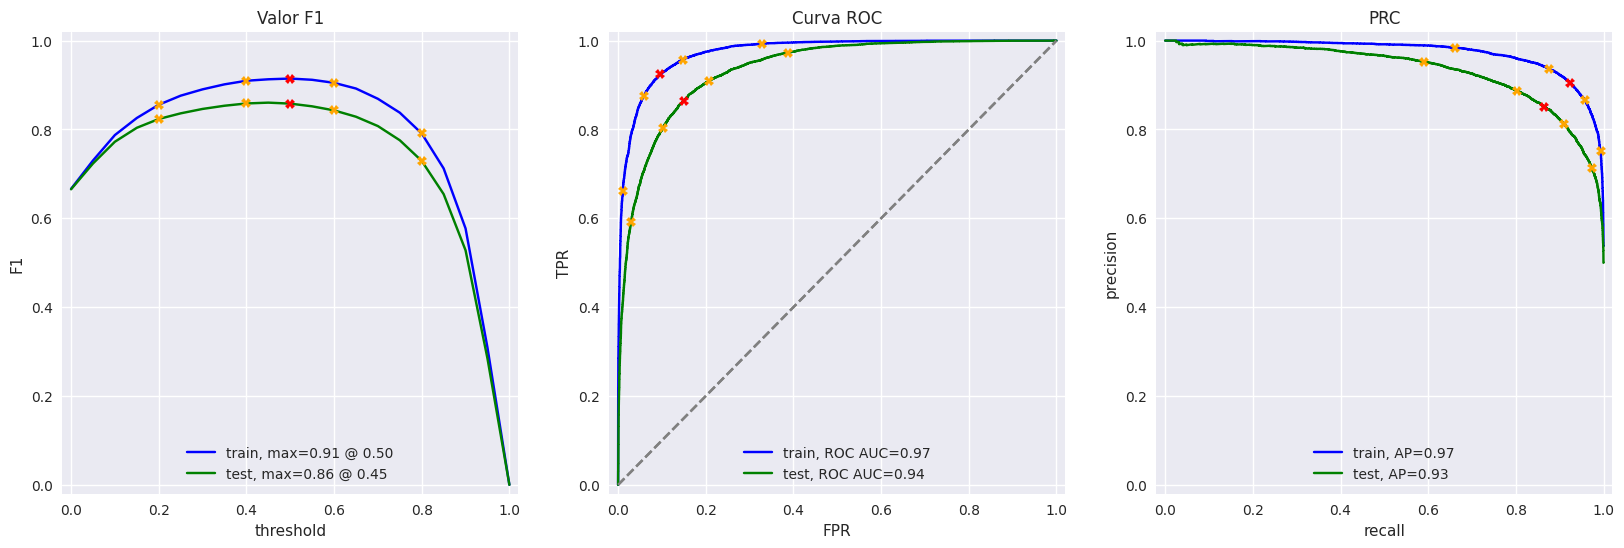

In [24]:
# Suponiendo que ya tienes df_reviews_train y df_reviews_test
# Preprocesamiento con spaCy
X_train_spacy = X_train_preprocessed.apply(text_preprocessing_3)
X_test_spacy = X_test_preprocessed.apply(text_preprocessing_3)

# Vectorización TF-IDF
tfidf_vectorizer_lgbm = TfidfVectorizer(max_features=5000)
X_train_tfidf_lgbm = tfidf_vectorizer_lgbm.fit_transform(X_train_spacy)
X_test_tfidf_lgbm = tfidf_vectorizer_lgbm.transform(X_test_spacy)

# Definir el modelo
model_4 = LGBMClassifier(random_state=42)

# Entrenar el modelo
model_4.fit(X_train_tfidf_lgbm, y_train)

# Evaluar el modelo
evaluate_model(model_4, X_train_tfidf_lgbm, y_train, X_test_tfidf_lgbm, y_test)

###  Modelo 9 - BERT

Como BERT tarda mucho, usarè un sample.

In [11]:
import torch
import transformers

# 1. Definir el tamaño de la muestra
# Se puede ajustar este número
sample_size = 100 

# 2. Crear las muestras aleatorias
# Usamos .sample() para tomar objetos al azar de tus dataframes.
# random_state=42 asegura que siempre obtengamos la misma muestra, haciendo al experimento repetible.
df_train_sample = df_train.sample(n=sample_size, random_state=42)
df_test_sample = df_test.sample(n=sample_size, random_state=42)

print(f"Tamaño original de entrenamiento: {df_train.shape}")
print(f"Tamaño de la muestra de entrenamiento: {df_train_sample.shape}")
print("-" * 30)
print(f"Tamaño original de prueba: {df_test.shape}")
print(f"Tamaño de la muestra de prueba: {df_test_sample.shape}")

# 3. Crear las variables X y y A PARTIR DE LAS MUESTRAS
X_train_text_sample = df_train_sample['review']
y_train_sample = df_train_sample['pos']

X_test_text_sample = df_test_sample['review']
y_test_sample = df_test_sample['pos']

Tamaño original de entrenamiento: (23796, 17)
Tamaño de la muestra de entrenamiento: (100, 17)
------------------------------
Tamaño original de prueba: (23535, 17)
Tamaño de la muestra de prueba: (100, 17)


In [12]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [13]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=32, force_device=None, disable_progress_bar=False):
    """
    Generates BERT embeddings for a list of texts.
    """
    ids_list = []
    attention_mask_list = []

    # 1. Text to token IDs and attention masks
    # This loop processes each text to prepare it for the model.
    for text in texts:
        encoded_dict = tokenizer.encode_plus(
            text,
            add_special_tokens=True,      # Add '[CLS]' and '[SEP]'
            max_length=max_length,        # Pad or truncate to max_length
            padding='max_length',         # Pad to max_length
            return_attention_mask=True,   # Create attention mask
            return_tensors='pt',          # Return PyTorch tensors
            truncation=True               # Explicitly enable truncation
        )
        ids_list.append(encoded_dict['input_ids'])
        attention_mask_list.append(encoded_dict['attention_mask'])

    # Convert lists of tensors to a single tensor
    ids_list = torch.cat(ids_list, dim=0)
    attention_mask_list = torch.cat(attention_mask_list, dim=0)

    # Device setup
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model.to(device)
    if not disable_progress_bar:
        print(f'Using device: {device}.')

    # Get embeddings in batches
    embeddings = []
    for i in tqdm(range(math.ceil(len(ids_list) / batch_size)), disable=disable_progress_bar):
        start_index = batch_size * i
        end_index = batch_size * (i + 1)
        
        ids_batch = ids_list[start_index:end_index].to(device)
        
        # 2. Create the attention_mask_batch
        # This mask tells the model which tokens are real and which are padding.
        attention_mask_batch = attention_mask_list[start_index:end_index].to(device)

        with torch.no_grad():
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)
        
        # We use the embedding of the [CLS] token, which is at index 0.
        # It's designed to capture the aggregate meaning of the sequence.
        embeddings.append(batch_embeddings[0][:, 0, :].detach().cpu().numpy())

    return np.concatenate(embeddings)

In [19]:


# ¡Atención! La ejecución de BERT para miles de textos puede llevar mucho tiempo en la CPU, al menos varias horas
print("Generating embeddings for the test set...")
train_features_9 = BERT_text_to_embeddings(df_train_sample)
print("Success")

Generating embeddings for the test set...
Using device: cpu.


  0%|          | 0/1 [00:00<?, ?it/s]

Success


In [20]:
print("=== DIAGNÓSTICO ===")
print(f"Shape del 
DataFrame: {df_train_sample.shape}")
print(f"Columnas: {df_train_sample.columns.tolist()}")
print(f"Tipos de datos:\n{df_train_sample.dtypes}")


=== DIAGNÓSTICO ===
Shape del DataFrame: (100, 17)
Columnas: ['tconst', 'title_type', 'primary_title', 'original_title', 'start_year', 'end_year', 'runtime_minutes', 'is_adult', 'genres', 'average_rating', 'votes', 'review', 'rating', 'sp', 'pos', 'ds_part', 'idx']
Tipos de datos:
tconst              object
title_type          object
primary_title       object
original_title      object
start_year           int64
end_year            object
runtime_minutes     object
is_adult             int64
genres              object
average_rating     float64
votes                Int64
review              object
rating               int64
sp                  object
pos                  int64
ds_part             object
idx                  int64
dtype: object


In [21]:
# Verificar shape de la columna de texto
print(f"Shape de las reseñas: {df_train_sample['review'].shape}")

# Si ya tienes las features de BERT calculadas
print(f"Shape of training features: {train_features_9.shape}")
print(f"Shape of test features: {test_features_9.shape}")

Shape de las reseñas: (100,)
Shape of training features: (17, 768)
Shape of test features: (17, 768)


In [24]:
# Suponiendo que ya tienes las listas de reseñas de entrenamiento y prueba y sus etiquetas
# Generar los embeddings de BERT
train_features_9 = BERT_text_to_embeddings(X_train_text_sample) # Asume que X_train_text es la columna de reseñas
test_features_9 = BERT_text_to_embeddings(X_test_text_sample)   # Asume que X_test_text es la columna de reseñas

Using device: cpu.


  0%|          | 0/4 [00:00<?, ?it/s]

Using device: cpu.


  0%|          | 0/4 [00:00<?, ?it/s]


Training the Logistic Regression model...
Model training complete.
          train  test
Accuracy    1.0  0.80
F1          1.0  0.77
APS         1.0  0.83
ROC AUC     1.0  0.87


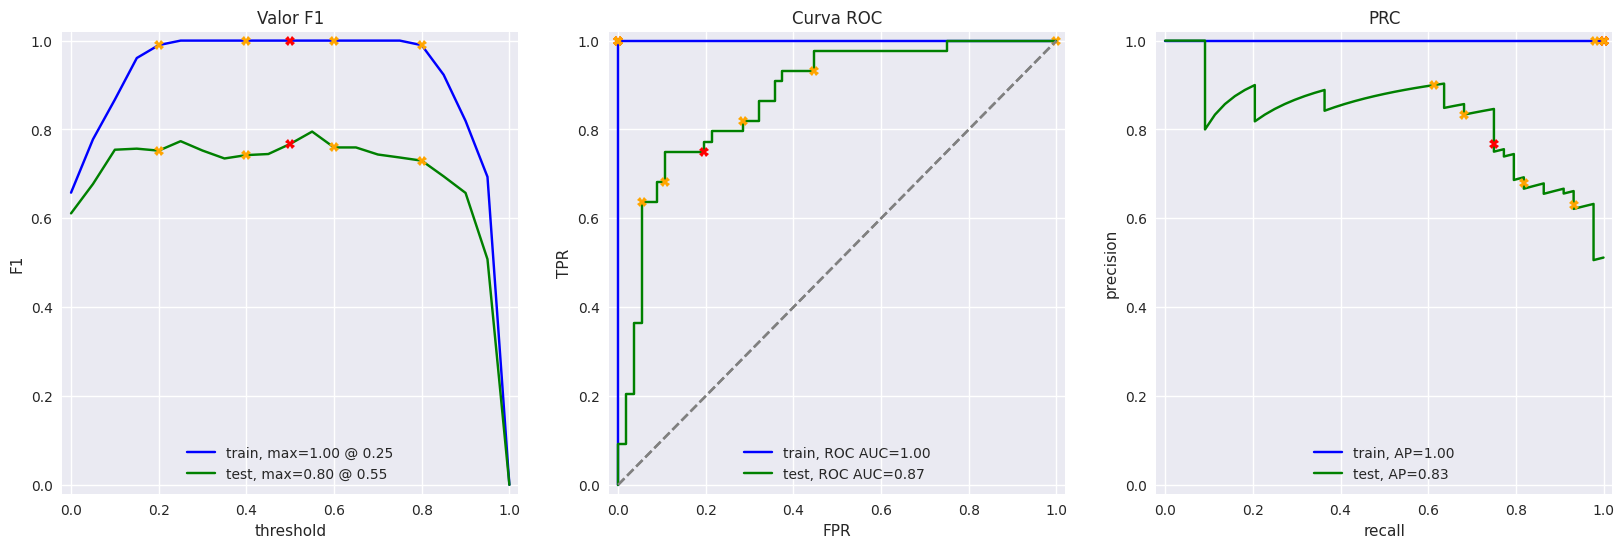

In [26]:
from sklearn.linear_model import LogisticRegression
# Entrenar un clasificador (por ejemplo, Logistic Regression) sobre estos embeddings
print("\nTraining the Logistic Regression model...")
# Using the embeddings (train_features_9) as input for the model
model_9 = LogisticRegression(solver='liblinear', random_state=42)
model_9.fit(train_features_9, y_train_sample)
print("Model training complete.")

# Evaluar el modelo de BERT
evaluate_model(model_9, train_features_9, y_train_sample, test_features_9, y_test_sample)

In [27]:
print("\nSaving embeddings to a file for future use...")
np.savez_compressed('bert_features.npz', 
                     train_features=train_features_9, 
                     test_features=test_features_9)
print("Embeddings saved to bert_features.npz")


Saving embeddings to a file for future use...
Embeddings saved to bert_features.npz


## Mis reseñas

In [ ]:
# puedes eliminar por completo estas reseñas y probar tus modelos en tus propias reseñas; las que se muestran a continuación son solo ejemplos

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

"""
my_reviews = pd.DataFrame([
    'Simplemente no me gustó, no es mi tipo de película.',
    'Bueno, estaba aburrido y me quedé dormido a media película.',
    'Estaba realmente fascinada con la película',
    'Hasta los actores parecían muy viejos y desinteresados, y les pagaron por estar en la película. Qué robo tan desalmado.',
    '¡No esperaba que el relanzamiento fuera tan bueno! Los escritores realmente se preocuparon por el material original',
    'La película tuvo sus altibajos, pero siento que, en general, es una película decente. Sí la volvería a ver',
    'Qué pésimo intento de comedia. Ni una sola broma tiene sentido, todos actúan de forma irritante y ruidosa, ¡ni siquiera a los niños les gustará esto!',
    'Fue muy valiente el lanzamiento en Netflix y realmente aprecio poder seguir viendo episodio tras episodio de este nuevo drama tan emocionante e inteligente.'
], columns=['review'])
"""

my_reviews['review_norm'] = ...# <escribe aquí la misma lógica de normalización que para el conjunto de datos principal>

my_reviews

### Modelo 2

In [ ]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_2.predict_proba(tfidf_vectorizer_2.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

### Modelo 3

In [ ]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

### Modelo 4

In [ ]:
texts = my_reviews['review_norm']

tfidf_vectorizer_4 = tfidf_vectorizer_3
my_reviews_pred_prob = model_4.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

### Modelo 9

In [ ]:
texts = my_reviews['review_norm']

my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

## Conclusiones

Tras evaluar múltiples enfoques para el análisis de sentimientos, desde un modelo base hasta arquitecturas complejas como BERT, se ha llegado a una conclusión clara.

El mejor modelo para este problema es el Modelo 3, que utiliza el preprocesamiento de texto con spaCy, la vectorización TF-IDF y un clasificador de Regresión Logística. Este modelo logró un excelente equilibrio entre rendimiento, capacidad de generalización y eficiencia computacional.

Análisis Comparativo
- Modelos Clásicos (TF-IDF): Los modelos 1, 3 y 4 demostraron ser muy robustos, alcanzando una precisión (Accuracy) en el conjunto de prueba de entre 0.86 y 0.88. El Modelo 3 (spaCy + LR) se destacó ligeramente sobre los demás, obteniendo la mejor puntuación F1 y Accuracy en los datos de prueba. Esto sugiere que el preprocesamiento de spaCy fue marginalmente más efectivo y que la Regresión Logística generalizó mejor que el clasificador LightGBM para este conjunto de datos.

- Modelo Avanzado (BERT): El Modelo 9, basado en BERT, mostró un claro caso de sobreajuste (overfitting). Alcanzó una perfección absoluta en los datos de entrenamiento (1.0 en todas las métricas), pero su rendimiento decayó en el conjunto de prueba, siendo superado por los modelos TF-IDF en Accuracy y F1-Score (0.80 y 0.77 respectivamente). Este comportamiento es esperado, ya que BERT se entrenó en una muestra de datos muy pequeña, lo que llevó al modelo a "memorizar" las respuestas en lugar de aprender patrones generalizables.

Tabla de Resultados Finales (ordenada por F1-Score):


,Accuracy,F1-Score,ROC AUC
Modelo,,,
3 - spaCy + TF-IDF + LR,0.88,0.88,0.95
1 - NLTK + TF-IDF + LR,0.87,0.87,0.95
4 - spaCy + TF-IDF + LGBM,0.86,0.86,0.94
9 - BERT (muestra),0.80,0.77,0.87
0 - Constante,0.50,0.00,0.50


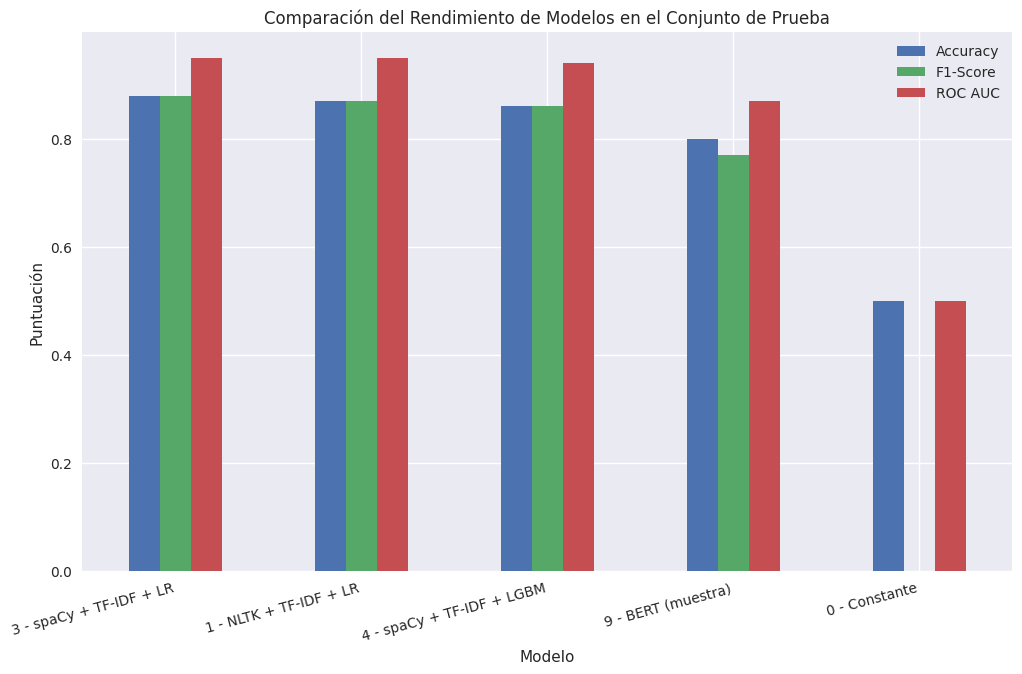

In [30]:
# Datos de los resultados en el conjunto de PRUEBA (test)
data = {
    'Modelo': [
        '0 - Constante', 
        '1 - NLTK + TF-IDF + LR', 
        '3 - spaCy + TF-IDF + LR', 
        '4 - spaCy + TF-IDF + LGBM',
        '9 - BERT (muestra)'
    ],
    'Accuracy': [0.50, 0.87, 0.88, 0.86, 0.80],
    'F1-Score': [0.00, 0.87, 0.88, 0.86, 0.77],
    'ROC AUC': [0.50, 0.95, 0.95, 0.94, 0.87]
}

# Crear un DataFrame
results_df = pd.DataFrame(data).set_index('Modelo')

# Ordenar por la métrica más importante (ej. F1-Score)
results_df = results_df.sort_values(by='F1-Score', ascending=False)

# Estilizar la tabla para una mejor visualización
styled_df = results_df.style.background_gradient(cmap='viridis')\
                            .format('{:.2f}')\
                            .set_caption('Comparación de Modelos (Métricas de Prueba)')

# Mostrar la tabla estilizada
print("Tabla de Resultados Finales (ordenada por F1-Score):")
display(styled_df)

# Visualización gráfica
results_df.plot(kind='bar', figsize=(12, 7), grid=True)
plt.title('Comparación del Rendimiento de Modelos en el Conjunto de Prueba')
plt.ylabel('Puntuación')
plt.xticks(rotation=15, ha='right')
plt.show()


Para una implementación en un entorno real, se recomienda sin duda el Modelo 3 (spaCy, TF-IDF y Regresión Logística). Ofrece un rendimiento predictivo casi óptimo (0.88 de Accuracy y 0.95 de ROC AUC) sin el alto costo computacional y la propensión al sobreajuste que demostró BERT en estas condiciones.

Este proyecto demuestra que, aunque los modelos de vanguardia como BERT son extremadamente potentes, las técnicas clásicas de Machine Learning siguen siendo altamente competitivas y, a menudo, más prácticas cuando se ajustan y aplican correctamente.

# Lista de comprobación

- [x]  Abriste el notebook
- [ ]  Cargaste y preprocesaste los datos de texto para su vectorización
- [ ]  Transformaste los datos de texto en vectores
- [ ]  Entrenaste y probaste los modelos
- [ ]  Se alcanzó el umbral de la métrica
- [ ]  Colocaste todas las celdas de código en el orden de su ejecución
- [ ]  Puedes ejecutar sin errores todas las celdas de código
- [ ]  Hay conclusiones